# Assignment 1: Building Neural Networks for Image Classification

## Overview
Welcome back to Assignment 1! In this assignment, you'll dive into the fascinating realm of deep learning by building and training neural networks for image classification and object detection tasks using the PyTorch framework. You'll work with two popular datasets: MNIST for image classification and CIFAR-100 for object detection. Throughout the assignment, you'll also fine-tune your models to achieve optimal results.

## Part 2: Image Classification on CIFAR-100
In the second part, your focus shifts to object classification using the CIFAR-100 dataset. This dataset contains images of various objects grouped into 100 classes. You'll again build both a fully connected neural network and a CNN, but this time, your models will classify objects from the CIFAR-100 dataset. Similar to the previous part, you will fine-tune the models, experimenting with different hyperparameters to achieve optimal results.

# Part 2a: Simple Fully Connected Neural Network - CIFAR 100 Dataset

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Specify font family to avoid font warnings on Colab
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Define hyperparameters
owner ='chuangm'
batch_size = 64
learning_rate = 0.001
epochs = 10
eval_every=1

#Load CIFAR-100 dataset and apply transformations

In [3]:
transform_train = transforms.Compose([
    # transforms.Resize(224),
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomVerticalFlip(p=0.5),
    # torchvision.transforms.RandomRotation(degrees=10),
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform_test = transforms.Compose([
    # transforms.Resize(224),
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 169001437/169001437 [00:05<00:00, 28716444.35it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Initialise Fully Connected Neural Network Archictecture

In [4]:
class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.flatten = nn.Flatten()

        # TODO: Define your own architecture for the fully connected network
        # You can add multiple linear layers followed by activation functions
        # Example: self.fc1 = nn.Linear(input_size, hidden_size)
        #          self.relu = nn.ReLU()
        #          self.fc2 = nn.Linear(hidden_size, num_classes) CIFAR HAS 100 classes
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(3072, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(2048, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.15),

            # torch.nn.Linear(1024, 1024),
            # torch.nn.BatchNorm1d(1024),
            # torch.nn.ReLU(),
            # torch.nn.Dropout(0.15),

            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),

            # torch.nn.Linear(512, 256),
            # torch.nn.BatchNorm1d(256),
            # torch.nn.ReLU(),
            # torch.nn.Dropout(0.1),

            torch.nn.Linear(512, 100),
        )

    def forward(self, x):
        x = self.model(x)

        return x
        # TODO: Implement the forward pass for the fully connected network
        # Apply the layers you defined in the __init__ function
        # pass

In [13]:
# Initialize the model
fc_model = FCModel().to(device)

# Define loss function and optimizer
fc_optimizer = torch.optim.AdamW(fc_model.parameters(), lr= learning_rate)# TODO: Use optim.SGD or another optimizer and provide the parameters and learning rate


class MyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(MyLoss, self).__init__()

    def forward(self, predictions, targets):
        # no use torch.nn
        one_hot = torch.zeros(predictions.shape).to(device)
        tragets_one_hot = one_hot.scatter(1,targets.view(-1,1),1)
        predictions = torch.log_softmax(predictions, dim=1)
        # predictions = nn.functional.one_hot(predictions,num_classes=100)
        loss = -torch.sum(predictions * tragets_one_hot, dim=1)
        return loss.mean()
criterion = MyLoss()

In [10]:
# initialize
def init_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)

# Apply Xavier initialization to all linear layers in the model
fc_model.apply(init_weights)

FCModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=2048, bias=True)
    (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=2048, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.1, inplace=False)
    (13): Linear(in_features=512, out_features=100, bias=True)
  )
)

# Training Model

In [11]:
scaler = torch.cuda.amp.GradScaler()

In [14]:
# Training loop
def train(model, optimizer, train_dataloader, test_dataloader, epochs):
    train_losses = []
    test_losses = []

    for epoch in range(20):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_dataloader:
            # TODO: Implement the following steps within this loop
            # 1. Zero the gradients
            optimizer.zero_grad()
            # 2. Perform a forward pass through the model to get predictions
            # 3. Calculate the loss between predictions and labels
            # 4. Perform a backward pass to compute gradients
            # 5. Update the model's parameters using the optimizer
            # 6. Accumulate the loss in a variable
            # 7. Save checkpoints if needed
            # print(inputs.shape)
            # print(labels.shape)
            inputs      = inputs.to(device)
            labels    = labels.to(device)
            # TODO Call model and get ouptuts
            with torch.cuda.amp.autocast():
              logits  = model(inputs)
            # TODO: Calculate the loss using loss function
            # TODO:Replace with your custom loss calculation
            # uncomment after defining below correctly

              loss    = criterion.forward(logits, labels)
            # call backward on loss
            # loss.backward()
            # TODO Add optimiser  step
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # After the loop, calculate the average training loss and append it to the train_losses list -TODO

        # Evaluate on the test set
        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{20} - Train Loss: {train_loss}, Test Loss: {test_loss}")

    return train_losses, test_losses

# Train the model and record train and test losses
# Define Hyper parameters
train_losses, test_losses, = train(fc_model,fc_optimizer,trainloader,testloader, epochs)

Epoch 1/20 - Train Loss: 3.7285638120778075, Test Loss: 3.4349446387807276
Epoch 2/20 - Train Loss: 3.326576081383259, Test Loss: 3.2283389674630136
Epoch 3/20 - Train Loss: 3.141976041562112, Test Loss: 3.109439666104165
Epoch 4/20 - Train Loss: 3.002842596119932, Test Loss: 3.06534396614998
Epoch 5/20 - Train Loss: 2.8748378220116697, Test Loss: 2.9762897612942254
Epoch 6/20 - Train Loss: 2.760315512452284, Test Loss: 2.953147423495153
Epoch 7/20 - Train Loss: 2.6410546956769645, Test Loss: 2.9057717080328875
Epoch 8/20 - Train Loss: 2.528171451042985, Test Loss: 2.910118151622213
Epoch 9/20 - Train Loss: 2.413223159435155, Test Loss: 2.893859190546024
Epoch 10/20 - Train Loss: 2.305675033260794, Test Loss: 2.890431130767628
Epoch 11/20 - Train Loss: 2.1874435251326205, Test Loss: 2.9027322113134297
Epoch 12/20 - Train Loss: 2.0698203205147667, Test Loss: 2.926344866965227
Epoch 13/20 - Train Loss: 1.9612493798555926, Test Loss: 2.9604246510062247
Epoch 14/20 - Train Loss: 1.83822954

# Visualize Final Results: FCN - CIFAR 100

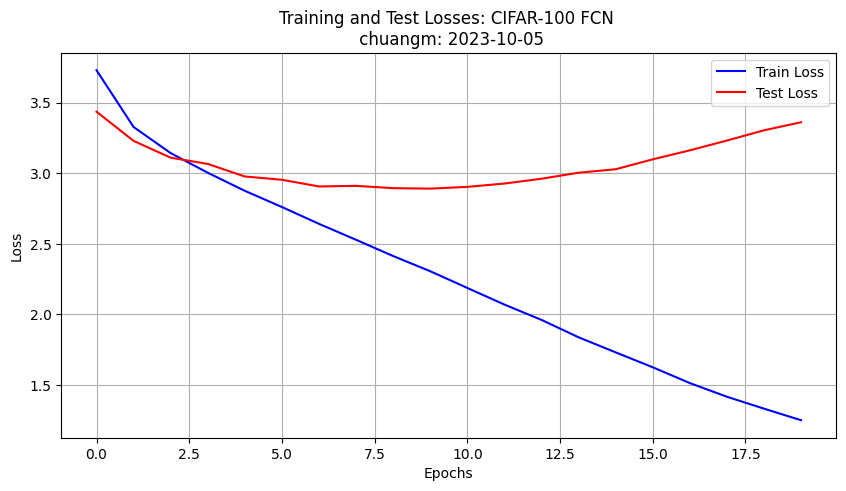

In [17]:
import datetime

current_datetime = datetime.datetime.now()
timestamp_str = current_datetime.strftime('%Y-%m-%d')

# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[::eval_every], label='Train Loss', color='blue') #plotting every 10th item
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Losses: CIFAR-100 FCN \n {owner}: {timestamp_str}')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Final Evaluation on Test Dataset for accuracy
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode (e.g., disables dropout)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

# Evaluate the model
fc_accuracy = evaluate(fc_model, testloader)

print("Final Fully Connected Model Test Accuracy:", fc_accuracy)

Final Fully Connected Model Test Accuracy: 31.72


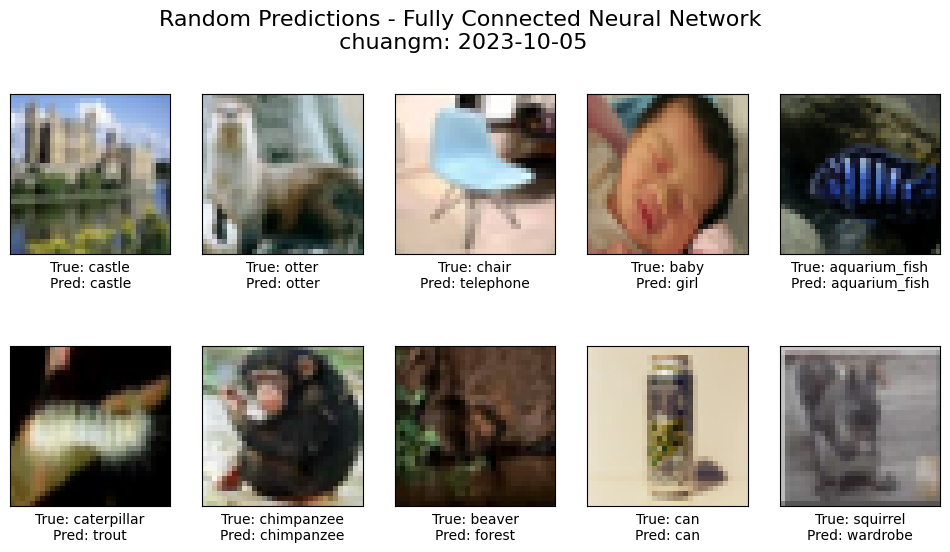

In [19]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch

current_datetime = datetime.datetime.now()
timestamp_str = current_datetime.strftime('%Y-%m-%d')

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize predictions
class_to_label = testset.classes

plt.figure(figsize=(12, 6))
random_inds = np.random.choice(len(testset), 10)

for i, image_idx in enumerate(random_inds):
    test_image, test_label = testset[image_idx]
    test_image = test_image.unsqueeze(0).to(device)  # Move input data to the selected device

    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((test_image.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2)  # Move image to CPU for plotting

    with torch.no_grad():
        output = fc_model(test_image)
        predicted_label_idx = torch.argmax(output).item()

    true_label = class_to_label[test_label]
    predicted_label = class_to_label[predicted_label_idx]

    plt.xlabel(f"True: {true_label}\nPred: {predicted_label}")

plt.suptitle(f'Random Predictions - Fully Connected Neural Network\n {owner}: {timestamp_str}', fontsize=16)
plt.show()

# Part 2b: Convolutional Neural Network - CIFAR 100 Dataset

In [20]:
# Define hyperparameters
owner ='chuangm'
batch_size = 64
learning_rate = 0.001
epochs = 5
eval_every=1

In [21]:
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# TODO: Define your CNNModel class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # TODO: Define your CNN layers here
        # You can experiment with the number of channels, kernel sizes, padding, etc.
        # Adjust input size for CIFAR-100, has 100 classes
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 192, 3)
        self.act = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc0 = nn.Linear(6912, 2048)
        self.fc1 = nn.Linear(2048, 100)
        self.BN = nn.BatchNorm1d(2048)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.flatten(x)  # Flatten the input

        x = self.fc0(x)
        x = self.BN(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc1(x)

        return x
        # TODO: Define the forward pass
        # Make sure to include the necessary layers and operations

In [23]:
# Initialize the CNN model
cnn_model = CNNModel().to(device)
# Print the model summary
# print(cnn_model)

# Define loss function and optimizer
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr= learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [24]:
# initialize
def init_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)

# Apply Xavier initialization to all linear layers in the model
cnn_model.apply(init_weights)

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=6912, out_features=2048, bias=True)
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (BN): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [25]:
# Training loop
def train(model, optimizer, train_dataloader, test_dataloader, epochs):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_dataloader:
             # TODO: Implement the following steps within this loop
             # 1. Zero the gradients
             # 2. Perform a forward pass through the model to get predictions
             # 3. Calculate the loss between predictions and labels
             # 4. Perform a backward pass to compute gradients
             # 5. Update the model's parameters using the optimizer
             # 6. Accumulate the loss in a variable
              # TODO: Implement the following steps within this loop
            # 1. Zero the gradients
            optimizer.zero_grad()
            # 2. Perform a forward pass through the model to get predictions
            # 3. Calculate the loss between predictions and labels
            # 4. Perform a backward pass to compute gradients
            # 5. Update the model's parameters using the optimizer
            # 6. Accumulate the loss in a variable
            # 7. Save checkpoints if needed
            inputs      = inputs.to(device)
            labels    = labels.to(device)
            # TODO Call model and get ouptuts
            logits  = model(inputs)
            # TODO: Calculate the loss using loss function
            # TODO:Replace with your custom loss calculation
            # uncomment after defining below correctly
            loss    = criterion(logits, labels)
            # call backward on loss
            loss.backward()
            # TODO Add optimiser  step
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_loss)
        # After the loop, calculate the average training loss and append it to the train_losses list -TODO

        # Evaluate on the test set
        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}")

    return train_losses, test_losses

# Train the CNN model and record losses
# Define Hyperparameters, if needed
cnn_train_losses, cnn_test_losses = train(cnn_model,cnn_optimizer,trainloader,testloader, epochs)

Epoch 1/5 - Train Loss: 3.265734184123671, Test Loss: 2.62166770400515
Epoch 2/5 - Train Loss: 2.2027173996581446, Test Loss: 2.3698419939940143
Epoch 3/5 - Train Loss: 1.5550211030046652, Test Loss: 2.215937801986743
Epoch 4/5 - Train Loss: 0.957629092056733, Test Loss: 2.347457156059848
Epoch 5/5 - Train Loss: 0.48886833980184075, Test Loss: 2.52830347209979


# Visualize Final Results: CNN - CIFAR 100

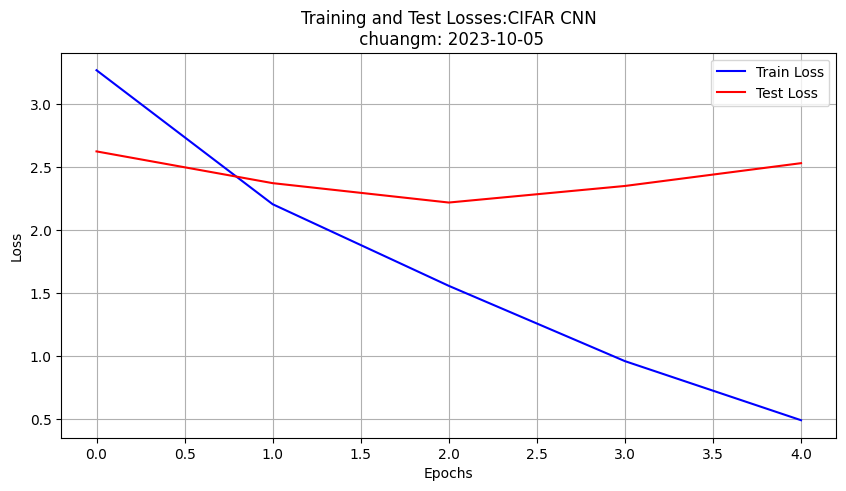

In [26]:
# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(cnn_train_losses[::eval_every], label='Train Loss', color='blue')
plt.plot(cnn_test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Losses:CIFAR CNN\n {owner}: {timestamp_str}')
plt.legend()
plt.grid()
plt.show()

In [27]:
# Final Evaluation on Test Dataset for accuracy
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode (e.g., disables dropout)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

# Evaluate the model
cnn_accuracy = evaluate(cnn_model, testloader)

print("CNN Model Test Accuracy:", cnn_accuracy)

CNN Model Test Accuracy: 44.96


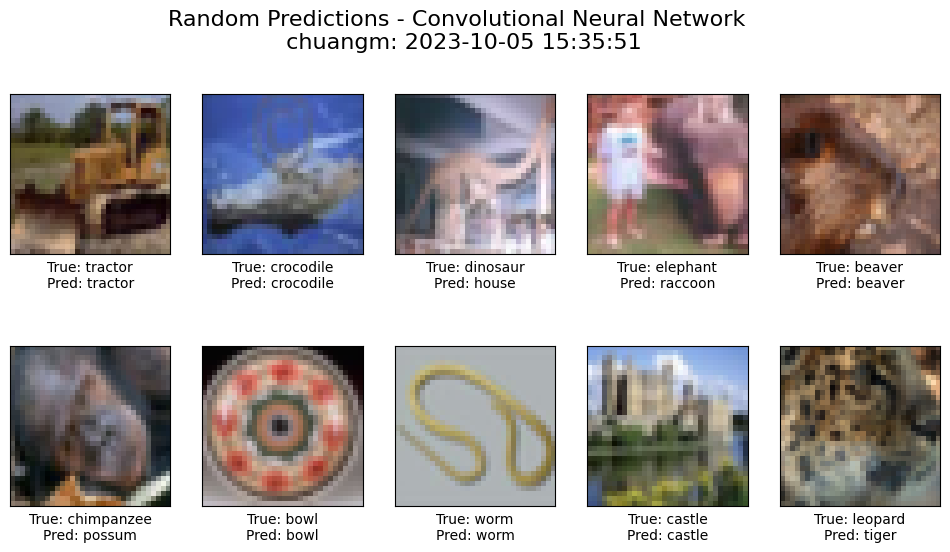

In [31]:
# Visualize predictions for CNN
import datetime
current_datetime = datetime.datetime.now()
timestamp_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
class_to_label = testset.classes

plt.figure(figsize=(12, 6))
random_inds = np.random.choice(len(testset), 10)

for i, image_idx in enumerate(random_inds):
    test_image, test_label = testset[image_idx]

    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((test_image.numpy().transpose(1, 2, 0) + 1) / 2)

    with torch.no_grad():
        output = cnn_model(test_image.unsqueeze(0).to(device))
        predicted_label_idx = torch.argmax(output).item()

    true_label = class_to_label[test_label]
    predicted_label = class_to_label[predicted_label_idx]

    plt.xlabel(f"True: {true_label}\nPred: {predicted_label}")

plt.suptitle(f'Random Predictions - Convolutional Neural Network \n {owner}: {timestamp_str}', fontsize=16)
plt.show()